## Image Analysis Evaluation

In [1]:
from glob import glob
from pathlib import Path

IMAGE_DIR = "./example_images"


# Get all the images in the directory and extract the file name
def get_image_files(directory=IMAGE_DIR):
    return [
        {
            "image_path": image,
            "messages": [],
            "chat_history": [],
            "actual_label": Path(image).stem.split("_")[0],
        }
        for image in glob(f"{directory}/*")
    ]

In [2]:
from farmGPT.agent_workflow import compile_graph
from langchain_core.runnables import RunnableLambda
from models import load_llm
from dotenv import load_dotenv

load_dotenv(override=True)
import re


def extract_name(text):
    for category in ["Pest", "Disease"]:
        pattern = rf"\*\*{category}\*\*: (.*?)\n\n"
        match = re.search(pattern, text)
        if match:
            return match.group(1)
    return None


model = load_llm(model="gpt-3.5-turbo-0125")
chain = compile_graph(llm=model) | (lambda x: x.content) | RunnableLambda(extract_name)

In [4]:
template = """
You are an agricultural expert tasked with evaluating the performance of an AI model designed to identify diseases, pests, and insects from images. 
The model will provide a prediction, and you will compare it with the actual label.

When evaluating the predictions, you should:

1. Disregard any spelling mistakes or minor variations in the predicted and actual labels.
2. Consider alternative names or synonyms for the diseases, pests, and insects.

For example, if the predicted label is "Corn Earworm" and the actual label is "Earworm on Corn," you should respond with "Y" since they refer to the same thing, despite the slight variation in wording.

Prediction: {prediction}

Actual Label: {actual_label}
"""

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq.chat_models import ChatGroq
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from langchain_core.runnables import RunnablePassthrough


class Evaluation(BaseModel):
    """Use this tool to evaluate the performance of an AI model designed to identify diseases, pests, and insects from images."""

    evaluation: Literal["Y", "N"] = Field(
        ...,
        description="Evaluation of the prediction. Reply with 'Y' if the prediction is accurate, and 'N' if it is inaccurate.",
    )
    prediction: str = Field(..., description="The predicted label.")
    actual_label: str = Field(..., description="The actual label.")


prompt = ChatPromptTemplate.from_template(template)
eval_chain = prompt | ChatGroq(
    model="Llama3-70b-8192", temperature=0
).with_structured_output(Evaluation)

c:\Users\PC\Cropify\.venv\lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The method `ChatGroq.with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [6]:
import time
import asyncio

full_chain = {"prediction": chain, "actual_label": RunnablePassthrough()} | eval_chain

score = []

image_files = get_image_files()
batch_size = 2
sleep_time = 80

for i in range(0, len(image_files), batch_size):
    batch = image_files[i : i + batch_size]
    output = await full_chain.abatch(batch, config={"max_concurrency": 2})
    for item in output:
        score.append(item.dict())
    if i + batch_size < len(image_files):
        time.sleep(sleep_time)

label='crop_disease'
label='crop_disease'
label='crop_disease'
label='crop_disease'
label='crop_disease'
label='pest'
label='pest'
label='crop_disease'
label='crop_disease'
label='pest'
label='pest'
label='crop_disease'
label='crop_disease'
label='crop_disease'
label='crop_disease'
label='pest'
label='crop_disease'
label='crop_disease'
label='crop_disease'
label='crop_disease'
label='pest'
label='crop_disease'


In [9]:
import json


with open("./evaluation_results.json", "w") as f:
    json.dump(score, f, indent=4)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [16]:
df = pd.read_json("./evaluation_results.json")
df.head()

,evaluation,prediction,actual_label
0,N,Apple Scab,Tomato Blight
1,Y,Aphid Infestation,Aphids
2,Y,Apple Scab,apple scab
3,Y,Apple Scab,applescab leaf
4,Y,Apple Scab,AppleScab


In [20]:
df["evaluation"] = df["evaluation"].map({"Y": 1, "N": 0})

print(f'Accuracy: {(df["evaluation"] == 1).mean()}')

Accuracy: 0.7727272727272727


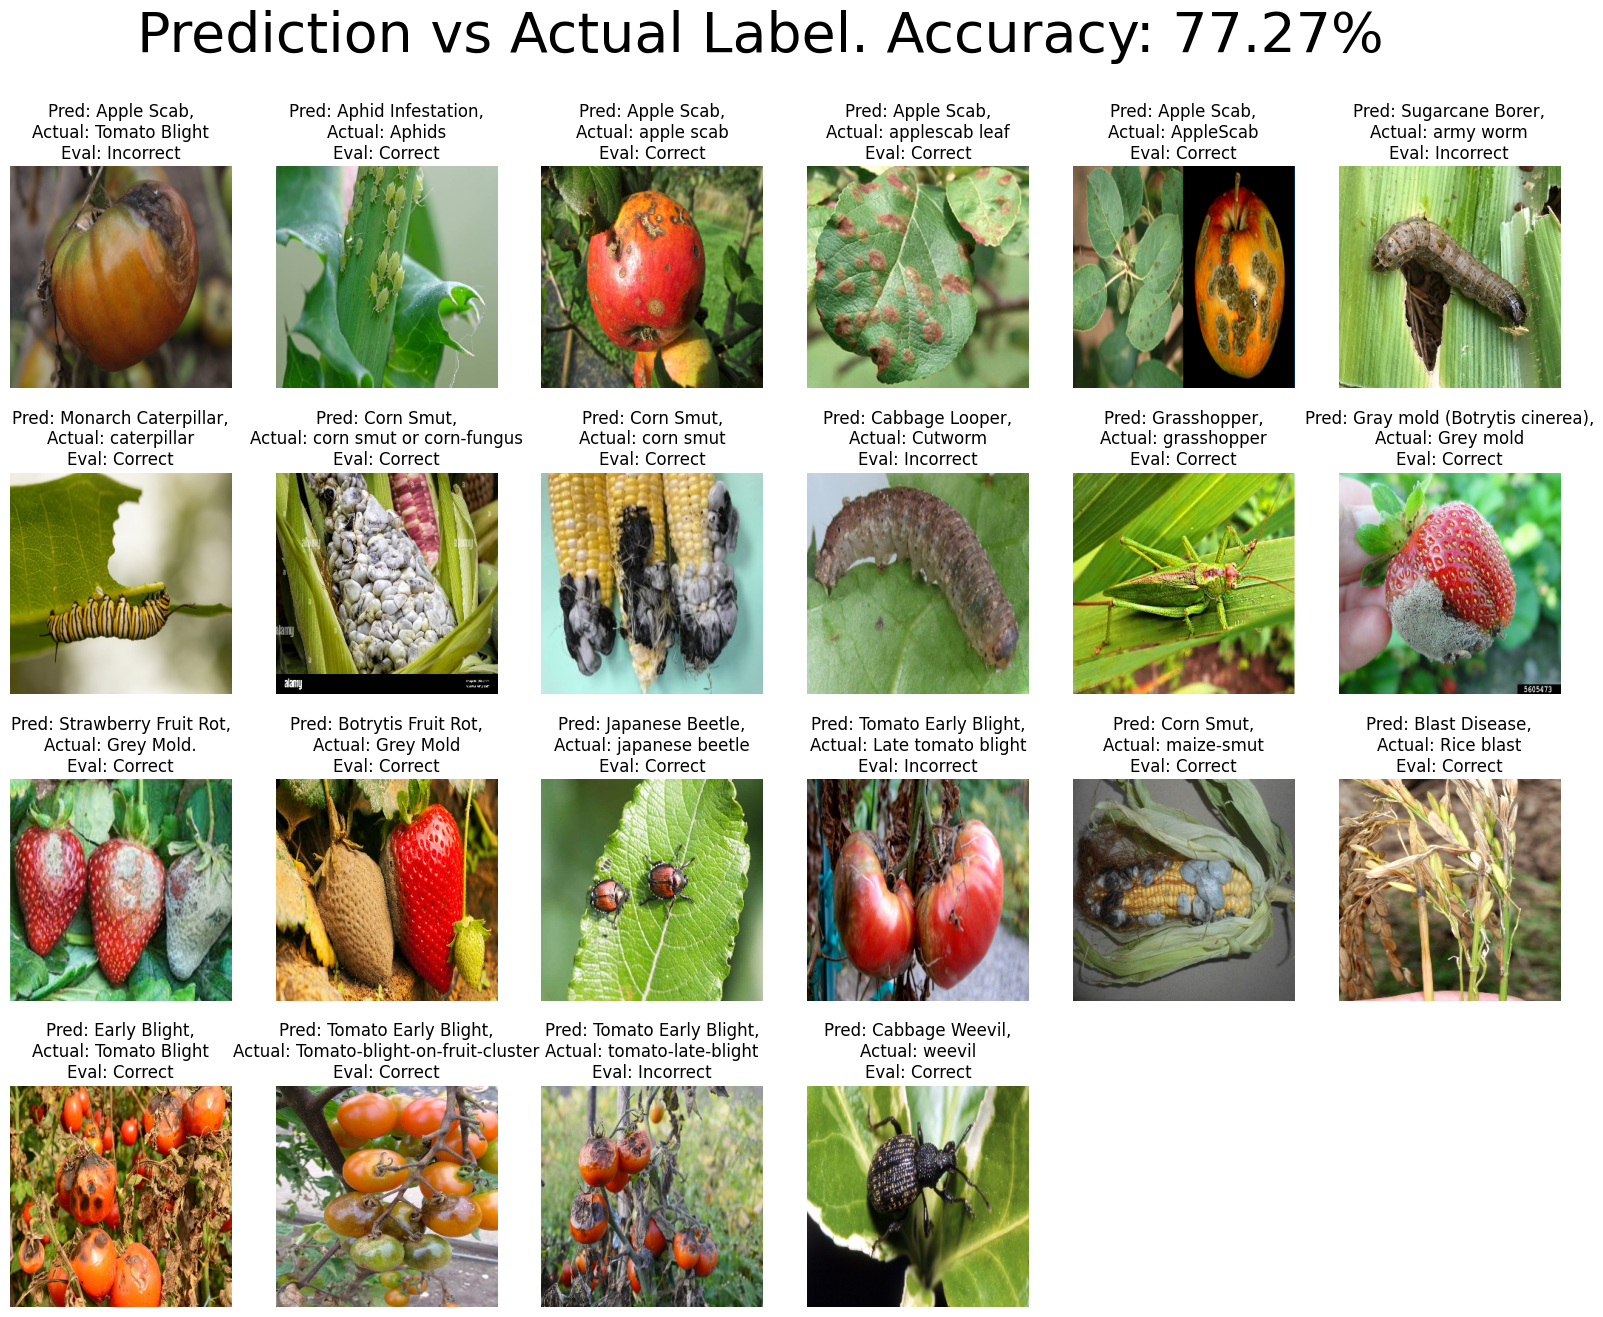

In [69]:
image_paths = glob(f"{IMAGE_DIR}/*")

fig, axes = plt.subplots(
    4,
    (len(image_paths) // 4) + 1,
    figsize=(20, 15),
    gridspec_kw={"hspace": 0.3, "wspace": 0.2},
)

for i, (image_path, ax) in enumerate(zip(image_paths, axes.flatten())):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (300, 300))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(
        f"Pred: {df.iloc[i, 1]},\nActual: {df.iloc[i, 2]}\nEval: {'Correct' if df.iloc[i, 0] == 1 else 'Incorrect'}",
        size=12,
    )
    ax.axis("off")

fig.suptitle(
    f"Prediction vs Actual Label. Accuracy: {(df['evaluation'] == 1).mean():.2%}",
    size=40,
)
for empty_ax in fig.get_axes()[-2:]:
    fig.delaxes(empty_ax)
plt.show()

## Chatbot Evaluation with langsmith

In [77]:
import langsmith
from langchain_core import prompts
from langchain_openai import chat_models
from langchain.evaluation.qa import eval_prompt
from langchain import smith
from langchain.schema import output_parser

from dotenv import load_dotenv

load_dotenv(override=True)


# Define your runnable or chain below.
prompt = prompts.ChatPromptTemplate.from_messages(
  [
    ("system", "You are a helpful AI assistant."),
    ("human", "{messages}")
  ]
)
llm = chat_models.ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
chain = (prompt | llm | output_parser.StrOutputParser()).with_retry()

# Define the evaluators to apply
eval_config = smith.RunEvalConfig(
    evaluators=[
        "qa"
    ],
    custom_evaluators=[],
    eval_llm=chat_models.ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
)

client = langsmith.Client()
chain_results = client.run_on_dataset(
    dataset_name="Cropify AI",
    llm_or_chain_factory=chain,
    evaluation=eval_config,
    project_name="ATF-hackathon-2024",
    concurrency_level=2,
    verbose=True,
)

View the evaluation results for project 'ATF-hackathon-2024' at:
https://smith.langchain.com/o/d0327f64-6893-5bd9-bf4a-aa9ec66fc7fa/datasets/4b817f88-9087-43bf-8203-4414c830b529/compare?selectedSessions=68321f62-abc5-4002-ac8b-0eb21091c641

View all tests for Dataset Cropify AI at:
https://smith.langchain.com/o/d0327f64-6893-5bd9-bf4a-aa9ec66fc7fa/datasets/4b817f88-9087-43bf-8203-4414c830b529
[------------------------------------------------->] 19/19

,feedback.correctness,error,execution_time,run_id
count,0,0,19.000000,19
unique,0,0,NaN,19
top,NaN,NaN,NaN,66304fc6-18de-4c82-ba65-88ce661e781e
freq,NaN,NaN,NaN,1
mean,NaN,NaN,33.955183,NaN
std,NaN,NaN,25.301595,NaN
min,NaN,NaN,1.408023,NaN
25%,NaN,NaN,14.583876,NaN
50%,NaN,NaN,32.765768,NaN
75%,NaN,NaN,45.233531,NaN
